<a href="https://colab.research.google.com/github/Rosalie-de-Vries/ACT_Monitoring_Waterways_test/blob/master/MASK_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip uninstall -y keras-nightly
!pip uninstall -y tensorflow

!pip uninstall -y h5py
!pip install 'h5py==2.10.0' --force-reinstall

!pip install keras==2.1.6
!pip install tensorflow==1.15.0

In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Mask_RCNN')

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image , ImageDraw
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
from keras.callbacks import Callback
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [ ]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "MASK-RCNN"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 2  # background + 1 shape

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. (Aim to allow ROI sampling to pick 33% positive ROIs.)
    TRAIN_ROIS_PER_IMAGE = 64

    # Use a small epoch since the data is simple 20
    STEPS_PER_EPOCH = 57
    # use small validation steps since the epoch is small 50
    VALIDATION_STEPS = 14

    WEIGHT_DECAY = 0.0001
    
config = ShapesConfig()
config.display()

## Notebook Preferences

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Load train and validation datasets


In [ ]:

TRAIN_ANNOTATIONS_FILE = '/content/drive/My Drive/Colab Notebooks/train/FINAL_TRAIN.json'
TRAIN_ANNOTATION_IMAGE_DIR = '/content/drive/My Drive/Colab Notebooks/train/images'
VALIDATION_ANNOTATIONS_FILE = '/content/drive/My Drive/Colab Notebooks/validation/FINAL_VAL.json'
VALIDATION_ANNOTATION_IMAGE_DIR = '/content/drive/My Drive/Colab Notebooks/validation/images'


dataset_train = modellib.CocoLikeDataset()
dataset_train.load_data(TRAIN_ANNOTATIONS_FILE, TRAIN_ANNOTATION_IMAGE_DIR)
dataset_train.prepare()

dataset_val = modellib.CocoLikeDataset()
dataset_val.load_data(VALIDATION_ANNOTATIONS_FILE, VALIDATION_ANNOTATION_IMAGE_DIR)
dataset_val.prepare()

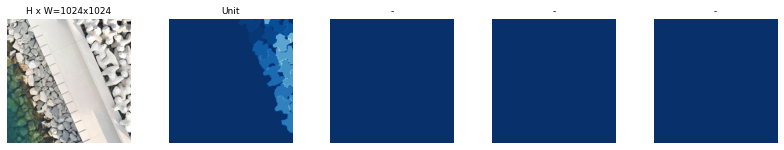

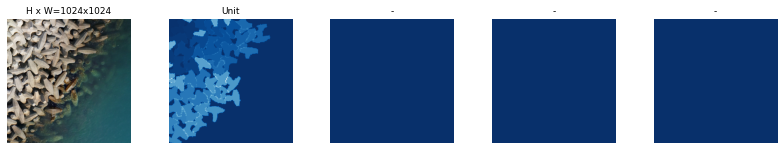

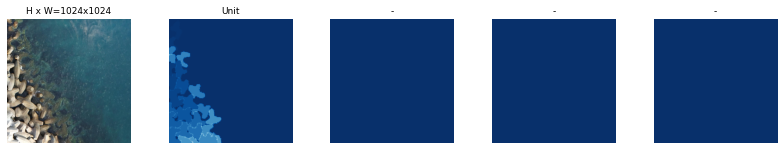

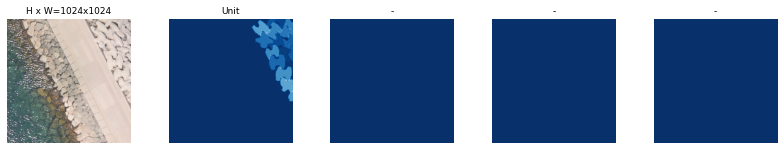

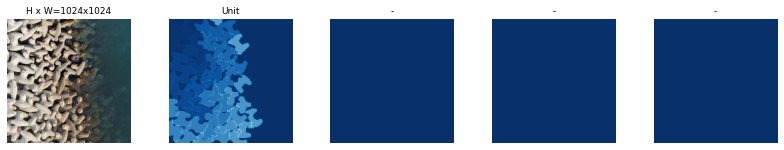

In [ ]:
# Load and display random samples

image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [ ]:
MODEL_DIR
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
model_inference = modellib.MaskRCNN(mode='inference', config=config, model_dir=MODEL_DIR)



Instructions for updating:
Use `tf.cast` instead.


In [ ]:
mean_average_precision_callback = modellib.MeanAveragePrecisionCallback(model,model_inference, dataset_val, calculate_map_at_every_X_epoch=1, verbose=1)

In [ ]:
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=2),
    #tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/Mask_RCNN/checkpoint/LATEST_model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.metrics.MeanIoU(num_classes=2),
    #mean_average_precision_callback,
    tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/Colab Notebooks/Mask_RCNN/logs'),
    ]

In [ ]:
#pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
import imgaug.augmenters as iaa
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
augmentation = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1)))
    ])


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=200, layers="all", augmentation=augmentation, custom_callbacks=my_callbacks)

# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_report_newbatch.h5")
model.keras_model.save_weights(model_path)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/logs/mask-rcnn20210710T1818/mask_rcnn_mask-rcnn_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'







Epoch 1/200
56/57 [============================>.] - ETA: 2s - loss: 12.5972 - rpn_class_loss: 3.0634 - rpn_bbox_loss: 5.7911 - mrcnn_class_loss: 0.7738 - mrcnn_bbox_loss: 2.3507 - mrcnn_mask_loss: 0.6181

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


57/57 [==============================] - 161s 3s/step - loss: 12.4451 - rpn_class_loss: 3.0131 - rpn_bbox_loss: 5.7151 - mrcnn_class_loss: 0.7681 - mrcnn_bbox_loss: 2.3293 - mrcnn_mask_loss: 0.6195 - val_loss: 3.8080 - val_rpn_class_loss: 0.2880 - val_rpn_bbox_loss: 1.2444 - val_mrcnn_class_loss: 0.5997 - val_mrcnn_bbox_loss: 0.9763 - val_mrcnn_mask_loss: 0.6996

Epoch 2/200
57/57 [==============================] - 72s 1s/step - loss: 3.2510 - rpn_class_loss: 0.3344 - rpn_bbox_loss: 0.9921 - mrcnn_class_loss: 0.5136 - mrcnn_bbox_loss: 0.7191 - mrcnn_mask_loss: 0.6918 - val_loss: 2.6958 - val_rpn_class_loss: 0.2432 - val_rpn_bbox_loss: 0.7693 - val_mrcnn_class_loss: 0.3594 - val_mrcnn_bbox_loss: 0.6351 - val_mrcnn_mask_loss: 0.6888
Epoch 3/200
57/57 [==============================] - 93s 2s/step - loss: 2.8609 - rpn_class_loss: 0.2374 - rpn_bbox_loss: 0.7307 - mrcnn_class_loss: 0.5467 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.6909 - val_loss: 2.8561 - val_rpn_class_loss: 0.2028 - v

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_32ROI_run2.h5")
model.keras_model.save_weights(model_path)

In [ ]:
print(MODEL_DIR)

/content/drive/MyDrive/logs


## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/logs/mask-rcnn20210710T1356/mask_rcnn_mask-rcnn_0150.h5
Re-starting from epoch 150


In [ ]:
model_path = os.path.join(MODEL_DIR, "shapes20210707T1628/mask_rcnn_shapes_0100.h5")
model.load_weights(model_path, by_name=True)

Re-starting from epoch 100


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (19,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (19, 4)               min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 19)      min:    0.00000  max:    1.00000  bool


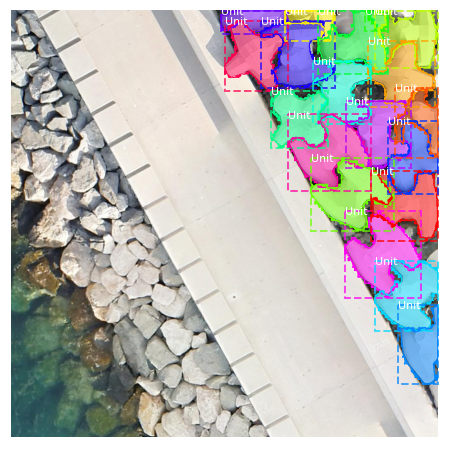

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


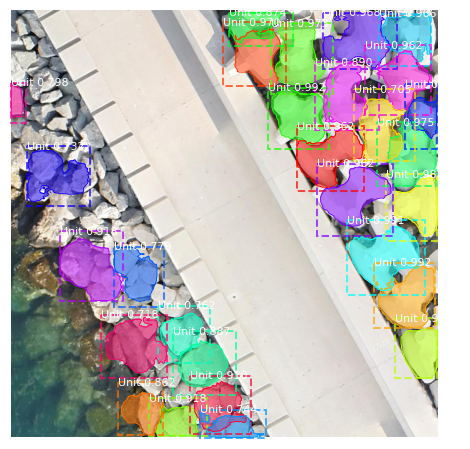

In [ ]:

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


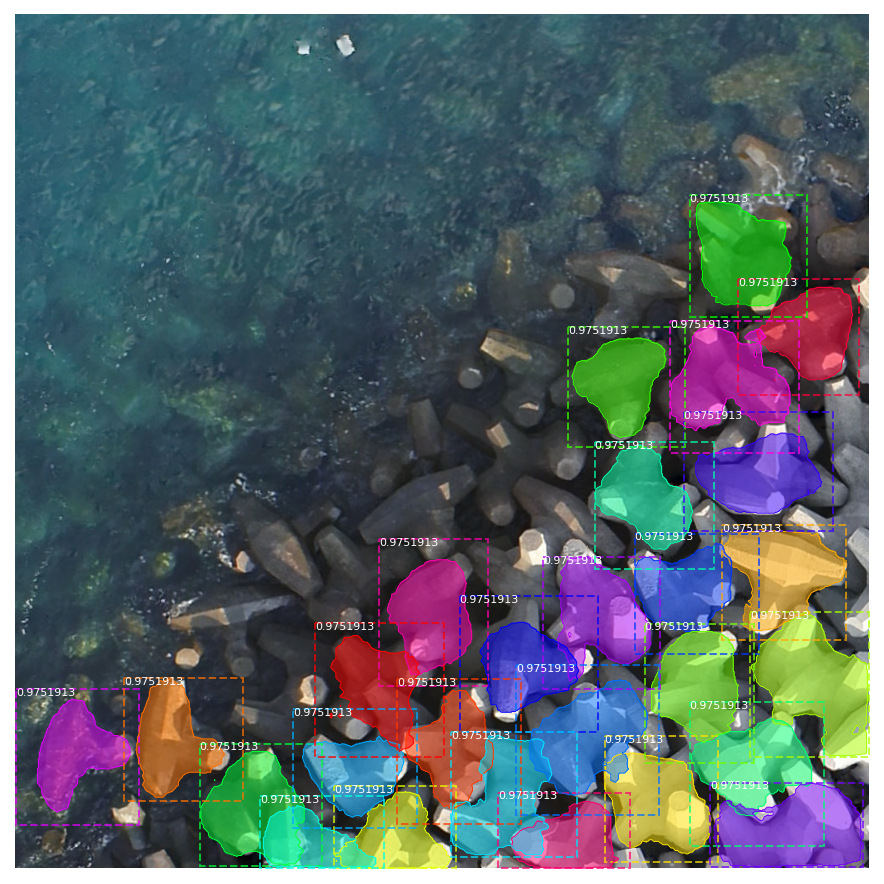

In [ ]:
import skimage
# Load a random image from the images folder
Test_Dir = '/content/drive/MyDrive/Colab Notebooks/Mask_RCNN/TEST'
file_names = next(os.walk(Test_Dir))[2]
image = skimage.io.imread(os.path.join(Test_Dir, file_names[2]))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], r['scores'])

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 40)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.3163496629684893


In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/logs'